In [100]:
import os
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
from scipy import ndimage
from scipy.signal import find_peaks

from utils.edge import get_slope, window_avg
from utils.edge import integral_intensity_projection, get_rotation_angle
from utils.shortcut import quick_get_roi

matplotlib.use('module://matplotlib_inline.backend_inline')
%matplotlib inline

load_dotenv()



True

In [101]:
data_dir = Path(os.getenv('DATASET_DIR')) / 'phase-2'


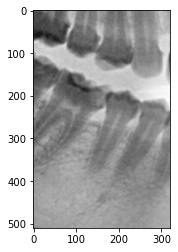

In [102]:
get_random = False
# get_random = True

image_names = list(data_dir.glob('00008026.jpg'))
image_path = image_names[0]
roi_index = 3

filename = image_path.stem

# im_g, flag, tooth_position = quick_get_roi(image_name=image_path, model=model, roi_index=roi_index)
im_g, flag, tooth_position, *_ = quick_get_roi(image_name=image_path, model=None, roi_index=roi_index, random_sample=get_random, image_dir=data_dir)

plt.imshow(1 - im_g, cmap='gray')
plt.show()


旋轉ROI並丟棄上方多於區域並免影響強度加總

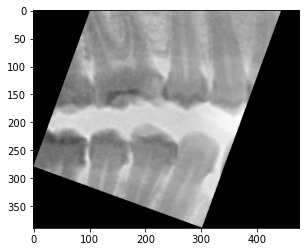

In [103]:
theta = get_rotation_angle(im_g, flag=flag, tooth_position=tooth_position)
source = ndimage.rotate(im_g, theta, reshape=True, cval=255)

margin = 30
padding = 200  # * abs(theta) // 10 + 1

if flag == 'lower':
    source = np.flip(source, axis=0)

source = source[padding:, :]

plt.imshow(1 - source, cmap='gray')
plt.show()


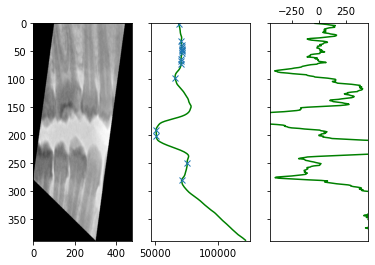

194

In [104]:
height, width = source.shape

hor, _ = integral_intensity_projection(source)
hor = window_avg(hor)
# TODO Add slope degree test when acc too low.
hor_slope = get_slope(hor)

hor_valleys, _ = find_peaks(hor * -1)

# Plot area
index = np.array(range(height))
fig, axs = plt.subplots(1, 3, sharey='all')
# row i col 0
# image = vertical_line_drawing(image, *window_position, color=0)
axs[0].imshow(1 - source, aspect='auto', cmap='gray')
# for v in default_return[:2]:
#     axs[0].axhline(y=v, color='r')

# row i col 1
axs[1].plot(hor, index, 'g')
# axs[i][1].xaxis.tick_top()
axs[1].set_ylim(height, 0)
axs[1].plot(hor[hor_valleys], hor_valleys, "x")
# for v in np.where(np.logical_and(hor_slope > -20, hor_slope < 20))[0]:
#     axs[1].axhline(y=v, color='r')

# row i col 2
axs[2].plot(hor_slope, index, 'g')
axs[2].xaxis.tick_top()
axs[2].set_ylim(height, 0)
axs[2].set_xlim(-hor_slope.std(), hor_slope.std())
# for v in np.where(np.logical_and(hor_slope > -10, hor_slope < 10))[0]:
#     axs[2].axhline(y=v, color='r')

plt.show()

jaw_sep_line = hor_valleys[hor[hor_valleys].argmin()]

jaw_sep_line
height // 2
# hor_valleys[hor_valleys < jaw_sep_line - 30]


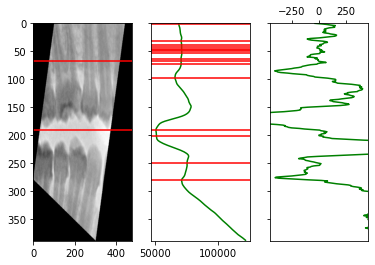

[67, 191]


In [105]:
jaw_sep_line = height
gum_sep_line = 0
default_return = [gum_sep_line, jaw_sep_line, hor_valleys, hor]

# hor_valleys = hor_valleys[hor_valleys < height - padding // 2]
# 假如沒有任何波谷則不放大
if hor_valleys.size > 0:
    jaw_sep_line = hor_valleys[hor[hor_valleys].argmin()]

    gum_sep_line_pool = hor_valleys[hor_valleys < jaw_sep_line - 30]
    if gum_sep_line_pool.size == 0:
        # 根據經驗推估一個可能的位置
        gum_sep_line = jaw_sep_line - 130
    else:
        gum_sep_line = gum_sep_line_pool[-1]

    gum_sep_line -= margin

if jaw_sep_line > height // 3:
    default_return[0] = gum_sep_line
    default_return[1] = jaw_sep_line

# Plot
index = np.array(range(height))

# Plot area
fig, axs = plt.subplots(1, 3, sharey='all')
# row i col 0
# image = vertical_line_drawing(image, *window_position, color=0)
axs[0].imshow(1 - source, aspect='auto', cmap='gray')
for v in default_return[:2]:
    axs[0].axhline(y=v, color='r')

# row i col 1
axs[1].plot(hor, index, 'g')
# axs[i][1].xaxis.tick_top()
axs[1].set_ylim(height, 0)
for v in hor_valleys:
    axs[1].axhline(y=v, color='r')

# row i col 2
axs[2].plot(hor_slope, index, 'g')
axs[2].xaxis.tick_top()
axs[2].set_ylim(height, 0)
axs[2].set_xlim(-hor_slope.std(), hor_slope.std())

plt.show()

print(default_return[:2])


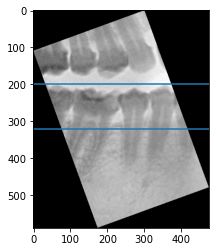

In [106]:
if flag == 'lower':
    default_return[0] = height - default_return[0]
    default_return[1] = height - default_return[1]

# Plot
source2 = ndimage.rotate(im_g, theta, reshape=True, cval=255)

plt.gray()
plt.axhline(default_return[0])
plt.axhline(default_return[1])
plt.imshow(1 - source2)
plt.show()


[  1  31  39  42  45  47  50  53  64  68  72  97 191 201 250 281]
[ 26  31  38  42  45  46  49  54  65  66  67  68 191 200 201 250 254]


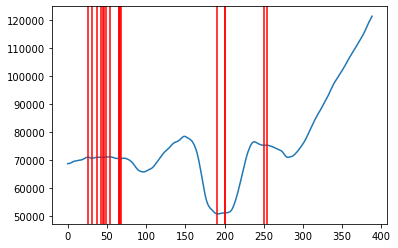

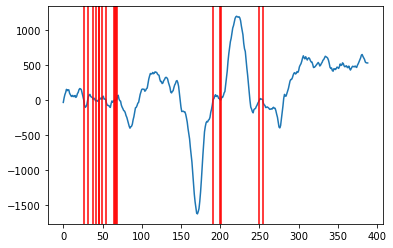

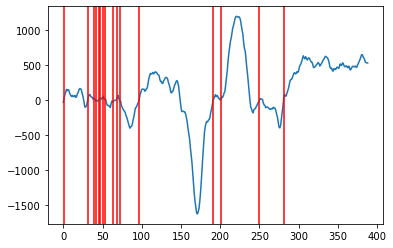

In [107]:
x = np.array(range(0, hor.shape[0]))

dy = np.gradient(hor)
dx = np.gradient(x)
d = np.gradient(hor, x)

# a = d[hor_valleys]

zero_points = np.where(abs(d) < 10)[0]

print(hor_valleys)
print(zero_points)

plt.plot(hor)
for i in zero_points:
    plt.axvline(x=i, color='r')
plt.show()

plt.plot(d)
for i in zero_points:
    plt.axvline(x=i, color='r')
plt.show()

plt.plot(hor_slope)
for i in hor_valleys:
    plt.axvline(x=i, color='r')
plt.show()
